In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split , cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error,accuracy_score
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.optimizers import SGD, adam
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, LeakyReLU, TimeDistributed, Flatten, Input, concatenate
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import layers
import os
from datetime import datetime
import math
from numpy import array
from numpy import hstack
plt.style.use('fivethirtyeight')

### COLLECT DATA

In [6]:
path = './SET_UPDATE'
dirs = os.listdir(path)
stock_list = ['SET50','SET']
df_stock={}
for stock in stock_list:
    # create list for stock data
    DATE = []
    OPEN = []
    HIGH = []
    LOW = []
    CLOSE = []
    VOL = []
    
    # load a file in dirs
    for file_name in dirs:
        df = pd.read_csv(path + '/' + file_name)
    
        if stock in df['<TICKER>'].values:               ###วนloop 
            quote = df[df['<TICKER>']==stock].values     ###เอาข้อมูลทั้งหมดในชื่อหุ้น ที่เราต้องการนั้นออกมา
        
            # get DATE
            date = datetime.strptime(str(quote[0][1]), '%Y%m%d')
            DATE.append(date)
            # get OPEN
            OPEN.append(quote[0][2])
            # get HIGH
            HIGH.append(quote[0][3])
            # get LOW
            LOW.append(quote[0][4])
            # get CLOSE
            CLOSE.append(quote[0][5])
            # get VOL
            VOL.append(quote[0][6])
            
    # create dataframe of each stock            
    col = ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']
    df_stock[stock] = pd.DataFrame(columns=col)
    #exec('{} = pd.DataFrame(columns=col)'.format(df_stock))
    df_stock[stock]['DATE']=DATE
    df_stock[stock]['OPEN']=OPEN
    df_stock[stock]['HIGH']=HIGH
    df_stock[stock]['LOW']=LOW
    df_stock[stock]['CLOSE']=CLOSE
    df_stock[stock]['VOL']=VOL
    df_stock[stock].set_index('DATE' ,inplace = True)
    
    
    df_stock[stock].to_csv(''+stock+'.csv')

In [7]:
SET=df_stock['SET']
SET

,OPEN,HIGH,LOW,CLOSE,VOL
DATE,,,,,
1975-04-30,100.00,100.00,100.00,100.00,163310
1975-05-02,99.96,99.96,99.96,99.96,150220
1975-05-06,99.53,99.53,99.53,99.53,260100
1975-05-07,99.13,99.13,99.13,99.13,35480
1975-05-08,97.88,97.88,97.88,97.88,52500
...,...,...,...,...,...
2020-06-05,1416.72,1438.09,1402.77,1435.70,25993504290
2020-06-08,1449.76,1454.95,1429.68,1438.66,23479056590
2020-06-09,1438.64,1448.13,1400.87,1408.37,26699932890


### Plotting

In [161]:
SET = pd.read_csv('SET.csv',index_col='DATE', parse_dates = ['DATE'])

In [162]:
train=SET[:'2010']
test=SET['2011':]

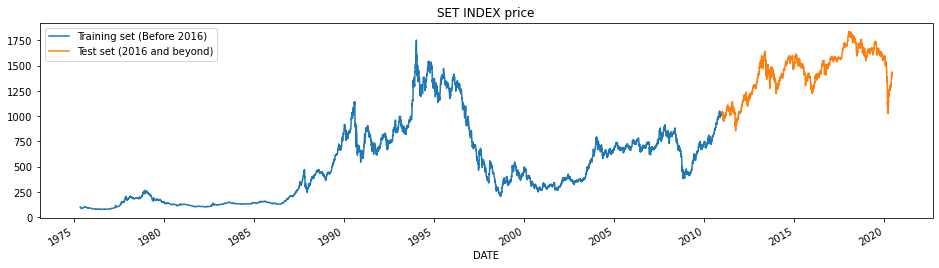

In [163]:
SET["CLOSE"][:'2010'].plot(figsize=(16,4),legend=True)
SET["CLOSE"]['2011':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2016)','Test set (2016 and beyond)'])
plt.title('SET INDEX price')
plt.show()

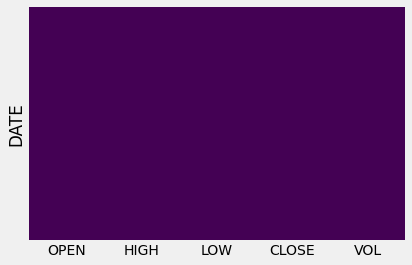

In [56]:
sns.heatmap(SET.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### Prepare for labelling

In [45]:
##*** Config params here ***##
shift = 5  ### this is T.forword
thr  = 0.3  ### this is threshold of percentiles 

In [58]:
train = train.reset_index()
train['DATE']= pd.to_datetime(train['DATE']).dt.strftime('%Y%m%d')
train['DATE']= train['DATE'].astype('int64')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8768 entries, 0 to 8767
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    8768 non-null   int64  
 1   OPEN    8768 non-null   float64
 2   HIGH    8768 non-null   float64
 3   LOW     8768 non-null   float64
 4   CLOSE   8768 non-null   float64
 5   VOL     8768 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 411.1 KB


In [59]:
train_date = train.iloc[:,0:1]  # แยกส่วนออกมาก่อนเพื่อที่จะไปทำ Standardize ได้
train = train.iloc[:,1:]
columns = train.columns.tolist()
columns

['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']

In [60]:
# train_set, test_set= np.split(data, [int(.7 *len(data))])  #thsi is split

In [61]:
test = test.reset_index()              ##**
test['DATE']= pd.to_datetime(test['DATE']).dt.strftime('%Y%m%d')
test['DATE']= test['DATE'].astype('int64')
test_date = test.iloc[:,0:1]  # แยกส่วนออกมาก่อนเพื่อที่จะไปทำ Standardize ได้
test = test.iloc[:,1:]
test = test.values                    ##**

In [62]:
train = train.values
sc = StandardScaler()
train = sc.fit_transform(train)
test = sc.transform(test)          ####****
train = pd.DataFrame(train,columns=columns)
train

,OPEN,HIGH,LOW,CLOSE,VOL
0,-1.102694,-1.103089,-1.102659,-1.102288,-0.514722
1,-1.102804,-1.103198,-1.102770,-1.102398,-0.514731
2,-1.103983,-1.104369,-1.103960,-1.103578,-0.514657
3,-1.105080,-1.105458,-1.105067,-1.104675,-0.514808
4,-1.108508,-1.108862,-1.108527,-1.108105,-0.514797
...,...,...,...,...,...
8763,1.428721,1.414467,1.438159,1.427240,0.871862
8764,1.429050,1.415638,1.438629,1.420299,0.832662
8765,1.421289,1.425550,1.438491,1.444635,1.420588
8766,1.453183,1.446926,1.473894,1.461809,1.459047


In [63]:
train = pd.concat([train_date,train],axis=1)
train

,DATE,OPEN,HIGH,LOW,CLOSE,VOL
0,19750430,-1.102694,-1.103089,-1.102659,-1.102288,-0.514722
1,19750502,-1.102804,-1.103198,-1.102770,-1.102398,-0.514731
2,19750506,-1.103983,-1.104369,-1.103960,-1.103578,-0.514657
3,19750507,-1.105080,-1.105458,-1.105067,-1.104675,-0.514808
4,19750508,-1.108508,-1.108862,-1.108527,-1.108105,-0.514797
...,...,...,...,...,...,...
8763,20101224,1.428721,1.414467,1.438159,1.427240,0.871862
8764,20101227,1.429050,1.415638,1.438629,1.420299,0.832662
8765,20101228,1.421289,1.425550,1.438491,1.444635,1.420588
8766,20101229,1.453183,1.446926,1.473894,1.461809,1.459047


In [64]:
test = pd.DataFrame(test,columns=columns)
test = pd.concat([test_date,test],axis=1)
test

,DATE,OPEN,HIGH,LOW,CLOSE,VOL
0,20110104,1.482636,1.480528,1.499414,1.483264,3.572973
1,20110105,1.487820,1.490222,1.510818,1.506227,3.359934
2,20110106,1.517273,1.501332,1.513586,1.506776,3.187496
3,20110107,1.504054,1.487853,1.488924,1.466912,2.821573
4,20110110,1.458558,1.444720,1.410064,1.416376,2.418368
...,...,...,...,...,...,...
2305,20200605,2.508262,2.540579,2.503391,2.562276,16.930856
2306,20200608,2.598870,2.586489,2.577877,2.570397,15.243270
2307,20200609,2.568375,2.567918,2.498132,2.487295,17.404980
2308,20200610,2.509139,2.500469,2.502533,2.515828,12.221300


## Compute Logarithm Return(rt)

In [89]:
df  = test    ###***** change dataframes hereee *****###

In [92]:
def log_return(df,shift): ### skip to next xxx days
    df['shift_val'] = df.CLOSE.shift(-shift)
    df['rt'] = np.log(df['CLOSE']/df['shift_val'])
    df.dropna(inplace = True)
    return df

In [93]:
log_return(df,shift)

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,shift_val,rt
0,20110104,1.482636,1.480528,1.499414,1.483264,3.572973,1.403646,0.055172
1,20110105,1.487820,1.490222,1.510818,1.506227,3.359934,1.420436,0.058644
2,20110106,1.517273,1.501332,1.513586,1.506776,3.187496,1.463153,0.029378
3,20110107,1.504054,1.487853,1.488924,1.466912,2.821573,1.455417,0.007867
4,20110110,1.458558,1.444720,1.410064,1.416376,2.418368,1.430533,-0.009945
...,...,...,...,...,...,...,...,...
2300,20200528,2.341799,2.324125,2.322724,2.292886,12.738514,2.562276,-0.111084
2301,20200529,2.280589,2.281319,2.282921,2.307537,12.316721,2.570397,-0.107880
2302,20200601,2.340071,2.334636,2.354529,2.333656,11.258468,2.487295,-0.063760
2303,20200602,2.357211,2.366849,2.377337,2.393492,10.982171,2.515828,-0.049848


In [94]:
null_columns=df.columns[df.isnull().any()]
null_columns

Index([], dtype='object')

In [95]:
columns = df.columns.tolist()
columns

['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL', 'shift_val', 'rt']

##  Descending order logarithm return 

In [96]:
## For test set ไม่ต้องทำตรงนี้ไปจนถึง..

In [73]:
df.sort_values(by='rt', ascending = False, inplace = True)
df

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,shift_val,rt
5497,19970822,0.213816,0.212246,0.151266,0.158621,-0.424624,0.001251,4.842562
5613,19980209,0.092932,0.114081,0.077749,0.078811,-0.361300,0.002074,3.637537
5629,19980304,0.098992,0.090118,0.077527,0.072611,-0.396650,0.002787,3.260002
6072,19991224,-0.096814,-0.096165,-0.102973,-0.111070,-0.173661,-0.009092,2.502747
5602,19980123,-0.223677,-0.218511,-0.228003,-0.216477,-0.395415,-0.017954,2.489681
...,...,...,...,...,...,...,...,...
5639,19980318,0.027745,0.019374,0.001878,-0.003605,-0.398388,-0.059546,-2.804409
5618,19980217,-0.034507,-0.006985,-0.027075,0.002074,-0.402707,0.041938,-3.006671
8231,20081014,-0.000556,0.010524,-0.000198,-0.002755,6.534618,-0.063058,-3.130791
5502,19970829,0.007424,-0.000804,-0.022480,0.001251,-0.453032,0.103695,-4.417500


## Define percentile for labelling method

In [74]:
def perc(data, percentiles):
    #data = np.sort(data)[::-1]
    #data = np.sort(data)
    N = len(data)
    pos =  percentiles*(N+1) -1   ##10.25
    c = math.ceil(pos)            ##11
    f = math.floor(pos)           ##10
    xx = pos - f
    yy = xx*(data[c]-data[f])
    return yy+data[f]   

In [75]:
df = df.values  ## ต้องทำเป็น values ก่อนถึงจะใช้ def perc ได้  ****ถ้า key error ให้รู้เลยว่าลืมทำเป็น array

In [76]:
thr_upper = perc(df,thr)[7]
thr_upper

0.01639173090851356

In [77]:
thr_lower = perc(df,1-thr)[7]
thr_lower

-0.017383269150263208

In [78]:
df = pd.DataFrame(df,columns=columns)
df

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,shift_val,rt
0,19970822.0,0.213816,0.212246,0.151266,0.158621,-0.424624,0.001251,4.842562
1,19980209.0,0.092932,0.114081,0.077749,0.078811,-0.361300,0.002074,3.637537
2,19980304.0,0.098992,0.090118,0.077527,0.072611,-0.396650,0.002787,3.260002
3,19991224.0,-0.096814,-0.096165,-0.102973,-0.111070,-0.173661,-0.009092,2.502747
4,19980123.0,-0.223677,-0.218511,-0.228003,-0.216477,-0.395415,-0.017954,2.489681
...,...,...,...,...,...,...,...,...
8691,19980318.0,0.027745,0.019374,0.001878,-0.003605,-0.398388,-0.059546,-2.804409
8692,19980217.0,-0.034507,-0.006985,-0.027075,0.002074,-0.402707,0.041938,-3.006671
8693,20081014.0,-0.000556,0.010524,-0.000198,-0.002755,6.534618,-0.063058,-3.130791
8694,19970829.0,0.007424,-0.000804,-0.022480,0.001251,-0.453032,0.103695,-4.417500


In [98]:
df.sort_values(by='DATE', ascending = True, inplace = True)  ## เรียงกลับมาในลำดับเดิม
df

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,shift_val,rt
0,20110104,1.482636,1.480528,1.499414,1.483264,3.572973,1.403646,0.055172
1,20110105,1.487820,1.490222,1.510818,1.506227,3.359934,1.420436,0.058644
2,20110106,1.517273,1.501332,1.513586,1.506776,3.187496,1.463153,0.029378
3,20110107,1.504054,1.487853,1.488924,1.466912,2.821573,1.455417,0.007867
4,20110110,1.458558,1.444720,1.410064,1.416376,2.418368,1.430533,-0.009945
...,...,...,...,...,...,...,...,...
2300,20200528,2.341799,2.324125,2.322724,2.292886,12.738514,2.562276,-0.111084
2301,20200529,2.280589,2.281319,2.282921,2.307537,12.316721,2.570397,-0.107880
2302,20200601,2.340071,2.334636,2.354529,2.333656,11.258468,2.487295,-0.063760
2303,20200602,2.357211,2.366849,2.377337,2.393492,10.982171,2.515828,-0.049848


## Labelling

In [99]:
def conditions(df):        
    if df['rt'] > thr_upper:
        return '1'
    elif df['rt'] < thr_lower:
        return '-1'
    else:
        return '0'

In [100]:
df['Label'] = df.apply(conditions, axis = 1)

In [101]:
df['Label'].value_counts()

0     1045
-1     718
1      542
Name: Label, dtype: int64

Text(0, 0.5, 'Frequency')

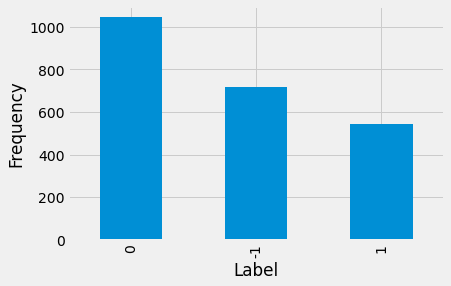

In [103]:
ax1 = df.Label.value_counts().plot(kind='bar')
ax1.set_xlabel('Label')
ax1.set_ylabel('Frequency')

### Handle imbalance data (random drop Label '0')

In [48]:
label='Label'

g = df.groupby(label, group_keys=False)
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()))).reset_index(drop=True)

In [49]:
df['Label'].value_counts()

-1    2609
1     2609
0     2609
Name: Label, dtype: int64

In [104]:
## Continue

In [105]:
df.sort_values(by='DATE', ascending = True, inplace = True)
# df.drop(['shift_val','rt','DATE'],inplace = True, axis = 1)
df

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,shift_val,rt,Label
0,20110104,1.482636,1.480528,1.499414,1.483264,3.572973,1.403646,0.055172,1
1,20110105,1.487820,1.490222,1.510818,1.506227,3.359934,1.420436,0.058644,1
2,20110106,1.517273,1.501332,1.513586,1.506776,3.187496,1.463153,0.029378,1
3,20110107,1.504054,1.487853,1.488924,1.466912,2.821573,1.455417,0.007867,0
4,20110110,1.458558,1.444720,1.410064,1.416376,2.418368,1.430533,-0.009945,0
...,...,...,...,...,...,...,...,...,...
2300,20200528,2.341799,2.324125,2.322724,2.292886,12.738514,2.562276,-0.111084,-1
2301,20200529,2.280589,2.281319,2.282921,2.307537,12.316721,2.570397,-0.107880,-1
2302,20200601,2.340071,2.334636,2.354529,2.333656,11.258468,2.487295,-0.063760,-1
2303,20200602,2.357211,2.366849,2.377337,2.393492,10.982171,2.515828,-0.049848,-1


In [106]:
df.to_csv('test_SET_0530AWOD2.csv')  ## For convenience

# ** Let's Modelling **

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import RepeatVector
from keras.layers import Reshape
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling2D
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate

from keras.models import load_model

from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import math
from numpy import array
from numpy import hstack

In [128]:
train = pd.read_csv('train_SET_tr005.csv',usecols = ['OPEN','HIGH','LOW','CLOSE','VOL','Label'])
train

,OPEN,HIGH,LOW,CLOSE,VOL,Label
0,100.00,100.00,100.00,100.00,163310,0.0
1,99.96,99.96,99.96,99.96,150220,0.0
2,99.53,99.53,99.53,99.53,260100,0.0
3,99.13,99.13,99.13,99.13,35480,-1.0
4,97.88,97.88,97.88,97.88,52500,-1.0
...,...,...,...,...,...,...
8762,1022.34,1024.77,1020.58,1021.27,2920729000,0.0
8763,1023.07,1024.54,1017.93,1021.99,2066129000,0.0
8764,1023.19,1024.97,1018.10,1019.46,2007722000,1.0
8765,1020.36,1028.61,1018.05,1028.33,2883713000,1.0


In [129]:
test = pd.read_csv('test_SET_tr005.csv',usecols = ['OPEN','HIGH','LOW','CLOSE','VOL','Label'])

### Split and Rolling windows

In [131]:
sc = StandardScaler()    

In [132]:
train[['OPEN','HIGH','LOW','CLOSE','VOL']] = sc.fit_transform(train[['OPEN','HIGH','LOW','CLOSE','VOL']])

In [133]:
test[['OPEN','HIGH','LOW','CLOSE','VOL']] = sc.transform(test[['OPEN','HIGH','LOW','CLOSE','VOL']])

In [134]:
train = train.values
test = test.values

In [135]:
# split a multivariate sequence into samples
n_steps = 30  # 30 days
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[i, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [136]:
X_train, y_train = split_sequences(train, n_steps)
print(X_train.shape, y_train.shape)

(8738, 30, 5) (8738,)


In [137]:
y_train_1hot = to_categorical(y_train, num_classes = 3)
y_train_1hot.shape

(8738, 3)

In [138]:
n_step, n_feature = X_train.shape[1], X_train.shape[2]

In [139]:
X_test, y_test = split_sequences(test, n_steps)
X_test = X_test.reshape( (X_test.shape[0], n_step, n_feature ))
y_test_1hot = to_categorical(y_test, num_classes = 3)

##### MFNN

In [143]:
n_step, n_feature = X_train.shape[1], X_train.shape[2]
epochs, batch_size, verbose = 60, 64, 2

lstm_input = Input(shape=(n_step,n_feature))  # Variable-length sequence of ints
cnn1_input = Input(shape=(n_step,n_feature))  # Variable-length sequence of ints
cnn2_input = Input(shape=(n_step,n_feature))


lstm_features = LSTM(128, activation='relu')(lstm_input)
# lstm_features = BatchNormalization()(lstm_features)


cnn1_features = Conv1D(64,3, activation='relu')(cnn1_input)
# cnn1_features = MaxPooling1D(pool_size=2)(cnn1_features)
# cnn1_features = BatchNormalization()(cnn1_features)
flat1 = Flatten()(cnn1_features)

cnn2_features = Conv1D(64,3, activation='relu')(cnn2_input)
cnn2_features = Conv1D(32,3, activation='relu')(cnn2_features)
# cnn2_features = MaxPooling1D(pool_size=2)(cnn2_features)
# cnn2_features = BatchNormalization()(cnn2_features)
flat2 = Flatten()(cnn2_features)

concat1 = concatenate([lstm_features, flat1, flat2])
##------------------------------------------------------##
# Output = Dense(20, activation='relu')(concat1)
Output = Dense(3 , activation='softmax', name="priority")(concat1)

model = Model(inputs=[lstm_input, cnn1_input, cnn2_input],outputs=[Output],)

In [144]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [145]:
history = model.fit([X_train,X_train,X_train], y_train_1hot, epochs=epochs, batch_size=batch_size, verbose=verbose, 
                   validation_data = ([X_test, X_test, X_test], y_test_1hot))


Train on 8738 samples, validate on 2280 samples
Epoch 1/60
 - 5s - loss: 1.0363 - accuracy: 0.4468 - val_loss: 1.2410 - val_accuracy: 0.4364
Epoch 2/60
 - 4s - loss: 1.0151 - accuracy: 0.4741 - val_loss: 1.2366 - val_accuracy: 0.5105
Epoch 3/60
 - 4s - loss: 0.9996 - accuracy: 0.5048 - val_loss: 7.5907 - val_accuracy: 0.5289
Epoch 4/60
 - 4s - loss: 0.9884 - accuracy: 0.5319 - val_loss: 1.1935 - val_accuracy: 0.4917
Epoch 5/60
 - 4s - loss: 0.9683 - accuracy: 0.5533 - val_loss: 1.4403 - val_accuracy: 0.5171
Epoch 6/60
 - 4s - loss: 0.9388 - accuracy: 0.5782 - val_loss: 1.5234 - val_accuracy: 0.4149
Epoch 7/60
 - 4s - loss: 0.8950 - accuracy: 0.6060 - val_loss: 1.2774 - val_accuracy: 0.5526
Epoch 8/60
 - 4s - loss: 0.8464 - accuracy: 0.6363 - val_loss: 1.8146 - val_accuracy: 0.5408
Epoch 9/60
 - 4s - loss: 0.7941 - accuracy: 0.6664 - val_loss: 1.0621 - val_accuracy: 0.6061
Epoch 10/60
 - 4s - loss: 0.7584 - accuracy: 0.6768 - val_loss: 1.3263 - val_accuracy: 0.5640
Epoch 11/60
 - 4s - 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


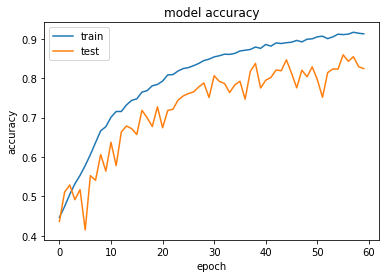

In [146]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# # plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [150]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30, 5)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30, 5)        0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 28, 64)       1024        input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 30, 5)        0                                            
____________________________________________________________________________________________

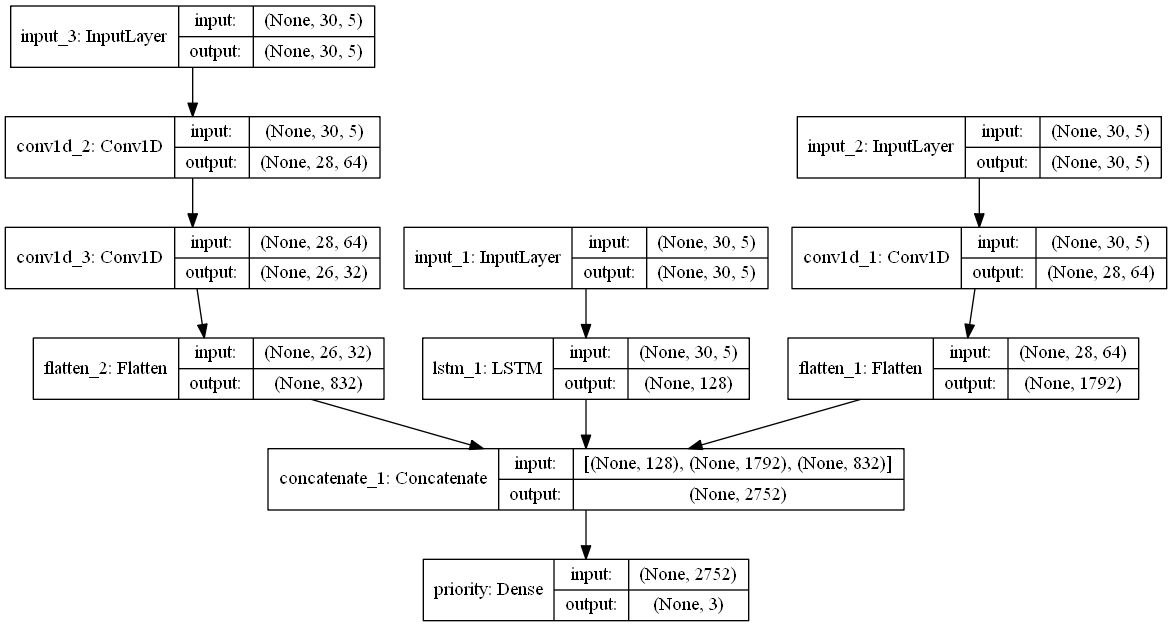

In [151]:
import os 
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [149]:
#plot_model(model, show_shapes=True, to_file='multi_DL.png')

In [18]:
X_test.shape

(2276, 30, 5)

In [16]:
accuracy = model.evaluate([X_test, X_test, X_test], y_test_1hot, batch_size=batch_size, verbose=0)

In [24]:
print('loss: {0} , accuracy: {1}'.format(accuracy[0], accuracy[1]))

loss: 0.7344779157470944 , accuracy: 0.7965729236602783


In [20]:
print('loss: {0} , accuracy: {1}'.format(accuracy[0], accuracy[1]))

loss: 0.8944635385997685 , accuracy: 0.803163468837738


In [17]:
print('loss: {0} , accuracy: {1}'.format(accuracy[0], accuracy[1]))

loss: 0.8385280015598492 , accuracy: 0.7671353220939636


In [152]:
model.save("C:\\Users\\User\\Desktop\\Proj.IS\\coding\\project_stock_chart\\ModelMF2.h5")

In [5]:
model = load_model('ModelMF1.h5')

In [19]:
y_pred = model.predict([X_test, X_test, X_test])

In [20]:
y_pred_arg = np.argmax(y_pred,axis=1)

In [21]:
print(len(X_test), len(y_pred), len(y_pred_arg))

2276 2276 2276


In [ ]:
### Market Simulations

In [23]:
records = X_test
for index, row in records.iterrows():
    print(row['Label'])

1.0
1.0
1.0
0.0
0.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
0.0
0.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
-1.0
-1.0
-1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
-1.0
0.0
-1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
0.0
0.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
-1.0
-1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
1.0
-1.0
0.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
1.0
0.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
0.0
1.

1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
-1.0
0.0
0.0
0.0
0.0
-1.0
-1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
-1.0
0.0
-1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
-1.0
-1.0
-1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
0.0
-1.0
0.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
0.0
0.0
0.0
-1.0
-1.0
-1.0
0.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0


In [24]:
for i in range(0,len(y_test_1hot)+1):
     print(y_test_1hot[i])

[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]

[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]

[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]

IndexError: index 2276 is out of bounds for axis 0 with size 2276

In [24]:
type(y_pred_arg)

numpy.ndarray

In [89]:
# shape = 2305
# Test = pd.read_csv('test_SET_0530AWOD2.csv',usecols = ['DATE','OPEN','HIGH','LOW','CLOSE','VOL'])

In [23]:
y_pred_label = pd.DataFrame(y_pred_arg,columns=['Label'])

In [24]:
Test['DATE'] = pd.to_datetime(Test['DATE']) 
mask = (Test['DATE'] >= '1-4-2011') & (Test['DATE'] <= '6-4-2020')
Test.loc[mask]
Test = Test.loc[mask]
Test = Test.reset_index(drop=True)

In [26]:
Test = pd.concat([Test,y_pred_label],axis=1)

In [27]:
Test.dropna(inplace = True, axis = 0)
Test.shape

(2276, 7)

In [28]:
Test

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,Label
0,2011-01-04,1042.73,1048.80,1040.06,1042.41,6090696000,1.0
1,2011-01-05,1044.62,1052.36,1044.18,1050.78,5773274000,1.0
2,2011-01-06,1055.36,1056.44,1045.18,1050.98,5516347000,1.0
3,2011-01-07,1050.54,1051.49,1036.27,1036.45,4971135000,0.0
4,2011-01-10,1033.95,1035.65,1007.78,1018.03,4370372000,0.0
...,...,...,...,...,...,...,...
2271,2020-04-14,1252.50,1267.55,1241.10,1256.35,14907522190,0.0
2272,2020-04-15,1253.92,1261.66,1233.66,1236.10,14429586260,2.0
2273,2020-04-16,1226.16,1231.05,1200.14,1200.15,12268587710,2.0
2274,2020-04-17,1230.34,1239.52,1218.57,1239.24,12397325350,2.0


In [29]:
y_pred_arg

array([1, 1, 1, ..., 2, 2, 0], dtype=int64)

In [30]:
Test['Label'].replace([0,1,2],['0','1','-1'],inplace=True)
Test['Label'] = Test['Label'].astype(float)

In [31]:
Test

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,Label
0,2011-01-04,1042.73,1048.80,1040.06,1042.41,6090696000,1.0
1,2011-01-05,1044.62,1052.36,1044.18,1050.78,5773274000,1.0
2,2011-01-06,1055.36,1056.44,1045.18,1050.98,5516347000,1.0
3,2011-01-07,1050.54,1051.49,1036.27,1036.45,4971135000,0.0
4,2011-01-10,1033.95,1035.65,1007.78,1018.03,4370372000,0.0
...,...,...,...,...,...,...,...
2271,2020-04-14,1252.50,1267.55,1241.10,1256.35,14907522190,0.0
2272,2020-04-15,1253.92,1261.66,1233.66,1236.10,14429586260,-1.0
2273,2020-04-16,1226.16,1231.05,1200.14,1200.15,12268587710,-1.0
2274,2020-04-17,1230.34,1239.52,1218.57,1239.24,12397325350,-1.0


In [32]:
# คำนวณผลตอบแทนของสินทรัพย์ ด้วยราคาปิด
shift = 5
Test['asset_return'] = Test.CLOSE.pct_change(periods=shift)
Test['shift_return'] = Test.asset_return.shift(-shift)
Test.tail

<bound method NDFrame.tail of            DATE     OPEN     HIGH      LOW    CLOSE          VOL  Label  \
0    2011-01-04  1042.73  1048.80  1040.06  1042.41   6090696000    1.0   
1    2011-01-05  1044.62  1052.36  1044.18  1050.78   5773274000    1.0   
2    2011-01-06  1055.36  1056.44  1045.18  1050.98   5516347000    1.0   
3    2011-01-07  1050.54  1051.49  1036.27  1036.45   4971135000    0.0   
4    2011-01-10  1033.95  1035.65  1007.78  1018.03   4370372000    0.0   
...         ...      ...      ...      ...      ...          ...    ...   
2271 2020-04-14  1252.50  1267.55  1241.10  1256.35  14907522190    0.0   
2272 2020-04-15  1253.92  1261.66  1233.66  1236.10  14429586260   -1.0   
2273 2020-04-16  1226.16  1231.05  1200.14  1200.15  12268587710   -1.0   
2274 2020-04-17  1230.34  1239.52  1218.57  1239.24  12397325350   -1.0   
2275 2020-04-20  1241.94  1273.25  1237.22  1266.40  16016832350    0.0   

      asset_return  shift_return  
0              NaN     -0.027839  

In [33]:
Test.head(5)

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,Label,asset_return,shift_return
0,2011-01-04,1042.73,1048.80,1040.06,1042.41,6090696000,1.0,NaN,-0.027839
1,2011-01-05,1044.62,1052.36,1044.18,1050.78,5773274000,1.0,NaN,-0.029759
2,2011-01-06,1055.36,1056.44,1045.18,1050.98,5516347000,1.0,NaN,-0.015129
3,2011-01-07,1050.54,1051.49,1036.27,1036.45,4971135000,0.0,NaN,-0.004043
4,2011-01-10,1033.95,1035.65,1007.78,1018.03,4370372000,0.0,NaN,0.005069


In [34]:
Test['strategy_return'] = (Test.shift_return * Test.Label*-1)
Test = Test.dropna(axis=0)

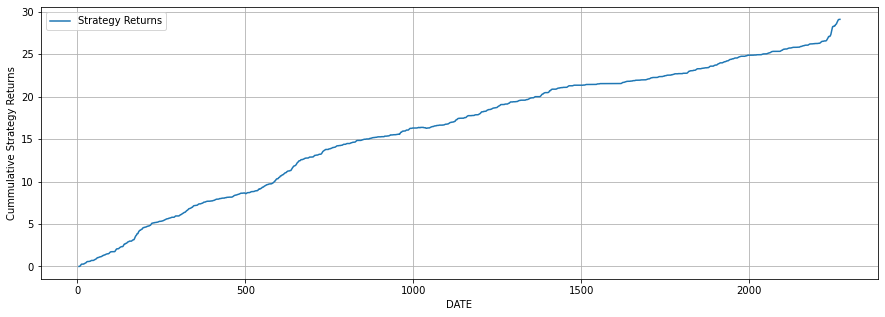

In [35]:
(Test.strategy_return).cumsum().plot(figsize=(15,5), label = "Strategy Returns")
plt.xlabel('DATE')
plt.ylabel('Cummulative Strategy Returns')
plt.legend()
plt.grid(True)
plt.show()

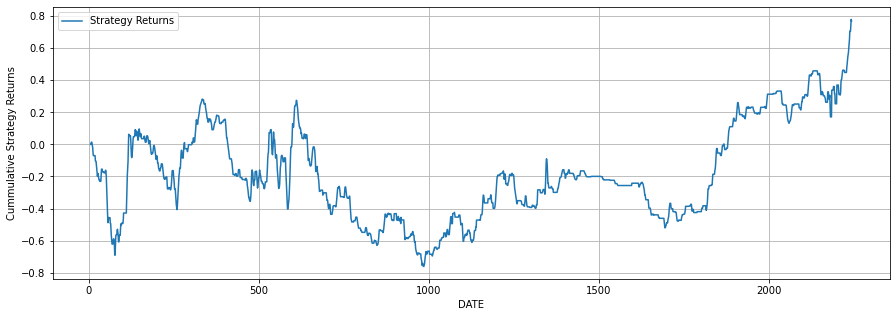

In [59]:
(Test.strategy_return).cumsum().plot(figsize=(15,5), label = "Strategy Returns")
plt.xlabel('DATE')
plt.ylabel('Cummulative Strategy Returns')
plt.legend()
plt.grid(True)
plt.show()

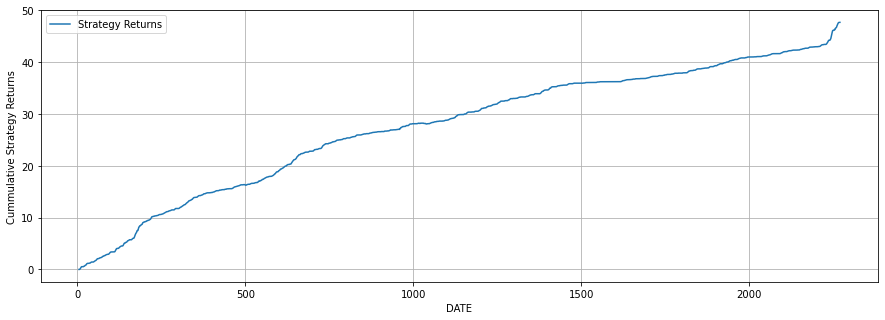

In [43]:
(Test.strategy_return).cumsum().plot(figsize=(15,5), label = "Strategy Returns")
plt.xlabel('DATE')
plt.ylabel('Cummulative Strategy Returns')
plt.legend()
plt.grid(True)
plt.show()

In [165]:
test

,OPEN,HIGH,LOW,CLOSE,VOL
DATE,,,,,
2011-01-04,1042.73,1048.80,1040.06,1042.41,6090696000
2011-01-05,1044.62,1052.36,1044.18,1050.78,5773274000
2011-01-06,1055.36,1056.44,1045.18,1050.98,5516347000
2011-01-07,1050.54,1051.49,1036.27,1036.45,4971135000
2011-01-10,1033.95,1035.65,1007.78,1018.03,4370372000
...,...,...,...,...,...
2020-06-05,1416.72,1438.09,1402.77,1435.70,25993504290
2020-06-08,1449.76,1454.95,1429.68,1438.66,23479056590
2020-06-09,1438.64,1448.13,1400.87,1408.37,26699932890


In [36]:
# sharpe ratio = ผลตอบแทนเมื่อเทียบกับความเสี่ยง1หน่วย(ยิ่งเยอะยิ่งดี)
# สมมติให้ average annual risk-free rate ในช่วงระยะเวลา 1 ปี คือ 2%(ผลตอบแทนเช่น bond ระยะสั้น)
risk_free_rate = 0.02/252

sharpe = np.sqrt(252)*(np.mean(Test.strategy_return)- (risk_free_rate))/np.std(Test.strategy_return)
print ("Sharpe Ratio : {:.5f}".format(sharpe))

Sharpe Ratio : 10.69653


dict_keys(['loss', 'accuracy'])


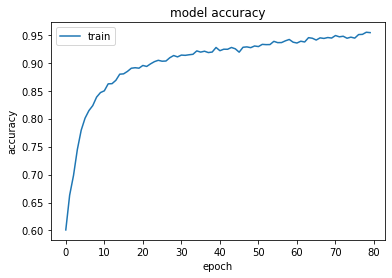

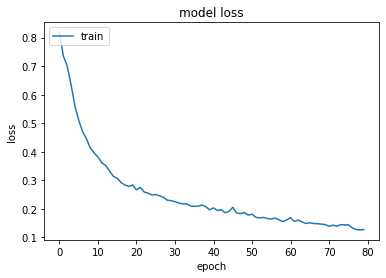

In [26]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# nvcc --version

In [ ]:
y_pred = sc.inverse_transform(y_pred)

In [ ]:
y_pred = np.argmax(y_pred, axis = 1)

### For using GPU

In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  #0 for activate , -1 for deactivate

In [20]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = False

In [21]:
#export CUDA_VISIBLE_DEVICES=""  ##deactivate
#unset CUDA_VISIBLE_DEVICES